In [21]:
import sys
import os, logging
import csv

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
import tensorflow as tf
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

[Data Preprocessing]

For demonstration, DO NOT need to run, preprocessed data already included.

Skip to "Load Preprocessed Dataset"

- Length: length of the URL
- Depth: the occurrence of ‘/’ character in the URL
- Numerical count: count of numeric characters
- Words count: count of English words present in the URL
- Special chars count: count of specials characters

Define chars for occurence counting

function to check for english words

In [2]:
LETTERS = 'abcdefghijklmnopqrstuwxyz'
NUMBERS = '0123456789'
SPEC_CHARS = ['+','\"','*','#','%','&','(',')','=','?','^','-','.','!','~','_','>','<']

def check_url_contains_words(url):
    found_words = []
    for letter in LETTERS:
        dictionary = open('dictionary/wb1913_{}.txt'.format(letter), 'rb')
        for line in dictionary.readlines():
            line = str(line)
            word = line.split('</B>')[0].replace('<P><B>', '').lower()
            if str(word) in url.lower() and len(word) > 1 and word not in found_words:
                found_words.append(word)
    return len(found_words)

Create csv and write data labels

In [3]:
preprocessed_data = open('preprocessed_data.csv', 'w')
preprocessed_data.write('len,spec_chars,depth,numericals_count,word_count,label\n')

62

Process dataset, very time consuming

In [ ]:
count = 0

for row in  csv.reader(open('url_data.csv', 'r'), delimiter = ','):
    spec_chars, depth, numericals_count, word_count = 0, 0, 0, 0
    
    
    if 'bad' in row[1].lower():
        label = '1'
    else:
        label = '0'

    url = str(row[0])
    # print(count, url, label)
    
    count += 1
    
    word_count = check_url_contains_words(url)
    
    for c in str(row[0]):
        if c in SPEC_CHARS:
            spec_chars += 1
        if c in ['/']:
            depth += 1
        if c in NUMBERS:
            numericals_count += 1
    preprocessed_data.write(str(len(row[0])) + ',' + str(spec_chars) + ',0,' + str(depth) + ',' + str(numericals_count) + ',' + str(word_count) + ',' + label + '\n')

Load Preprocessed Dataset

In [4]:
df = pd.read_csv("preprocessed_data.csv")

# Dimension of the dataset
print(df.shape)

(420465, 6)


Split training and testing data 80/20

In [6]:
X_train, X_test = train_test_split(df, test_size=0.2)

# Take only the normal cases
X_train = X_train[X_train.label == 0]
X_train = X_train.drop(['label'], axis=1)

y_test = X_test['label']
X_test = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test = X_test.values


Select the size of the encoding/input layer. 

In [7]:
input_dim = X_train.shape[1]
encoding_dim = input_dim

Build the feedforward autoencoder model.

In [8]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(encoding_dim-1), activation="relu")(encoder)

encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)

code = Dense(int(encoding_dim-3), activation='tanh')(encoder)

decoder = Dense(int(encoding_dim-2), activation='tanh')(code)

decoder = Dense(int(encoding_dim-1), activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 4)                 24        
                                                                 
 dense_2 (Dense)             (None, 3)                 15        
                                                                 
 dense_5 (Dense)             (None, 4)                 16        
                                                                 
 dense_6 (Dense)             (None, 5)                 25        
                                                                 
Total params: 110
Trainable params: 110
Non-trainable params:

2022-12-06 22:28:02.180402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 22:28:02.180578: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 22:28:02.180743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alex-desktop): /proc/driver/nvidia/version does not exist
2022-12-06 22:28:02.181599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set the parameters, callbacks and train the model. 

In [9]:
nb_epoch = 2
batch_size = 60

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

Epoch 1/2
4549/4596 [============================>.] - ETA: 0s - loss: 475.3298 - accuracy: 0.6859
Epoch 1: val_loss improved from inf to 429.47394, saving model to model.h5
4596/4596 [==============================] - 5s 968us/step - loss: 473.6167 - accuracy: 0.6891 - val_loss: 429.4739 - val_accuracy: 0.9991
Epoch 2/2
4562/4596 [============================>.] - ETA: 0s - loss: 207.5836 - accuracy: 0.9991
Epoch 2: val_loss improved from 429.47394 to 262.55435, saving model to model.h5
4596/4596 [==============================] - 4s 913us/step - loss: 207.0716 - accuracy: 0.9991 - val_loss: 262.5544 - val_accuracy: 0.9991


Load from the saved model.

In [10]:
autoencoder = load_model('model.h5')

Make predictions on the test data

In [11]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
fraud_error_df = error_df[error_df['true_class'] == 1]

2628/2628 [==============================] - 1s 520us/step


Calibrate the threshold value

In [18]:
threshold=0
f1=0
recall=0
accuracy=0

threshold = 35

while (accuracy < 0.6):
    

    threshold += .005
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    
    conf_matrix = metrics.confusion_matrix(error_df.true_class, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    precision = 1. * tp / (tp + fp)
    recall = 1. * tp / (tp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    accuracy = 1. * (tp + tn) / (tp + tn + fp + fn)
    
    print('\nThreshold: {}  ::  Recall: {}  ::  Accuracy: {}  '.format(threshold, 
                                                                      recall, accuracy))


Threshold: 35.005  ::  Recall: 0.4018511119989346  ::  Accuracy: 0.5989083514680176  

Threshold: 35.010000000000005  ::  Recall: 0.4018511119989346  ::  Accuracy: 0.5989321346604355  

Threshold: 35.01500000000001  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5989202430642265  

Threshold: 35.02000000000001  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5989321346604355  

Threshold: 35.02500000000001  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5989440262566444  

Threshold: 35.030000000000015  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5989678094490624  

Threshold: 35.03500000000002  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5989797010452713  

Threshold: 35.04000000000002  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5989915926414803  

Threshold: 35.04500000000002  ::  Recall: 0.4016513517112798  ::  Accuracy: 0.5991105086035698  

Threshold: 35.050000000000026  ::  Recall: 0.4015847649487282  ::  Accuracy: 0.5991105086035698  

Threshold: 35.0550000000000

Print metrics 

In [19]:

print('TP:' + str(tp))
print('FP:' + str(fp))
print('TN:' + str(tn))
print('FN:' + str(fn))

print('Accuracy:' + str(accuracy))
print('Precision:' + str(precision))
print('Recall:' + str(recall))
print('F1:' + str(f1))

TP:6011
FP:24629
TN:44446
FN:9007
Accuracy:0.6000142699154507
Precision:0.19618146214099216
Recall:0.4002530296976961
F1:0.26330544482894563


Plot confusion matrix

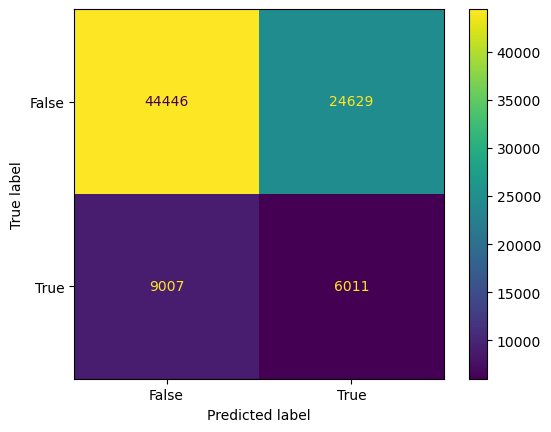

In [20]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()